In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,cross_validate
import catboost
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import plotly.express as px
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import plotly.io as pio
pio.templates.default = "plotly_dark"
sns.set_style("darkgrid")
pd.set_option.row_count = 50


In [75]:
events = pd.read_csv("./events.csv")

In [76]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


# events dataframe exploration

In [77]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [78]:
events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid'], dtype='object')

In [79]:
print("Number of evnets is ",events.shape[0])

Number of evnets is  2756101


In [80]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


**Convert timestamp to Readable date format**

In [81]:
import datetime
times =[]
for time in events.timestamp:
    times.append(datetime.datetime.fromtimestamp(time//1000)) 
events["timestamp"] = times

In [82]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 07:02:12,257597,view,355908,NaN
1,2015-06-02 07:50:14,992329,view,248676,NaN
2,2015-06-02 07:13:19,111016,view,318965,NaN
3,2015-06-02 07:12:35,483717,view,253185,NaN
4,2015-06-02 07:02:17,951259,view,367447,NaN


In [83]:
events.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

**About 99% of the transaction_id column is null which means that the purchased items are not many**

In [86]:
events.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [84]:
print("number of unique visitors: ",events.visitorid.nunique())

number of unique visitors:  1407580


In [85]:
print("non-null transaction id: ",(events.transactionid.isnull()==0).sum())
print("unique transaction id: ",events.transactionid.nunique())

non-null transaction id:  22457
unique transaction id:  17672


#### Remove Duplicates

In [87]:
print("original entries= ",events.shape[0])
events.drop_duplicates(inplace=True)
print("after removing duplicates= ",events.shape[0])

original entries=  2756101
after removing duplicates=  2752009


In [88]:
buyersList = events[events.event=="transaction"]["visitorid"]
print("number of visitors who acctually purchased items is: " ,buyersList.nunique())

number of visitors who acctually purchased items is:  11719


## Let's build our recommendation model
   - At first we create dataframe of all transaction events

In [93]:
transc_df = events[events.event=="transaction"]
transc_df.head()

,timestamp,visitorid,event,itemid,transactionid
130,2015-06-02 07:17:56,599528,transaction,356475,4000.0
304,2015-06-01 23:18:20,121688,transaction,15335,11117.0
418,2015-06-01 23:25:15,552148,transaction,81345,5444.0
814,2015-06-01 18:38:56,102019,transaction,150318,13556.0
843,2015-06-01 18:01:58,189384,transaction,310791,7244.0


**we will make a better representation of the itemid and visitor id**

In [94]:
buyers = transc_df['visitorid'].unique()
items = transc_df['itemid'].unique()
transc_df['buyers'] = transc_df['visitorid'].apply(lambda x : np.argwhere(buyers == x)[0][0])
transc_df['items'] = transc_df['itemid'].apply(lambda x : np.argwhere(items == x)[0][0])

/tmp/ipykernel_64731/2565408624.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_64731/2565408624.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [95]:
transc_df.head()

,timestamp,visitorid,event,itemid,transactionid,buyers,items
130,2015-06-02 07:17:56,599528,transaction,356475,4000.0,0,0
304,2015-06-01 23:18:20,121688,transaction,15335,11117.0,1,1
418,2015-06-01 23:25:15,552148,transaction,81345,5444.0,2,2
814,2015-06-01 18:38:56,102019,transaction,150318,13556.0,3,3
843,2015-06-01 18:01:58,189384,transaction,310791,7244.0,4,4


### *That's a little bit better*

In [96]:
transc_df.buyers.nunique()

11719

**We have 11719 unique buyer out of 22451**

### *To build our model we neet to construct buyer-item matrix and item-item matrix*
   - To do so we with normal matirx we gonna need huge amount of memory to store the values,Instead we gonna use sparse matrix

In [97]:
from scipy.sparse import csr_matrix

In [98]:
occurences = csr_matrix((buyers.shape[0], items.shape[0]), dtype='int8')
def set_occurences(buyers, item):
    occurences[buyers, item] += 1
transc_df.apply(lambda row: set_occurences(row['buyers'], row['items']), axis=1)
occurences

/home/eslam/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



<11719x12025 sparse matrix of type '<class 'numpy.int8'>'
	with 21270 stored elements in Compressed Sparse Row format>

**From 140 Million value only 221270 are stored so memory usage is imporved by 99.9%**

### Now let's construct item-item co-occurrence matrix  with the same way
 - A beautiful way to do so is to multiply the the occurence matrix by its transpose

In [100]:
cooc = occurences.transpose().dot(occurences)
cooc.setdiag(0) # ignoring the item occerance with itself

- The cooc matrix holds the number of ocerances of row items with column items

In [101]:
cooc.shape

(12025, 12025)

- **Sort the result, so that the highest number of ocerances in each item is on the first column of each row.**

In [102]:
def recommended_items(bought_items,cooc_matrix):
    recommended_items = []
    ocerances = []
    for item in bought_items:
        number = np.flip(np.sort(cooc_matrix.A, axis=1), axis=1)
        items = np.flip(np.argsort(cooc_matrix.A, axis=1), axis=1)
        number = number[item][number[item]>3]
        
        recommended_items.append(list(items[item,:len(number)]))
        ocerances.append(list(number))
        
    recommended_items = [item for sublist in recommended_items for item in sublist]
    ocerances = [item for sublist in ocerances for item in sublist]
    return recommended_items,ocerances

In [103]:
bought_items = [380]
recommended_item,numbers = recommended_items(bought_items,cooc)

In [104]:
print("people who bought {0} also bought {1}".format(bought_items,recommended_item))
print("with number of ocerances: ",numbers)

people who bought [380] also bought [8456, 8682]
with number of ocerances:  [17, 16]


- We can say that with a high number of ocerances, item 8456 and 8682 can be an indicator for item 380.  

# Predict abnormal user

In [105]:
visitors = events.visitorid.sort_values().unique()
buyers = events[events.event == 'transaction'].visitorid.sort_values().unique()
viewers = list(set(visitors) - set(buyers))

In [106]:
print("Out of {0} unique visitors there are only {1} visitor who bought something\nand {2} visitor who only viewed items ".format(len(visitors),len(buyers),len(viewers)))

Out of 1407580 unique visitors there are only 11719 visitor who bought something
and 1395861 visitor who only viewed items 


In [107]:
view_count = events[events.event == "view"].groupby("visitorid").size().reset_index(name='counts')
bought_count = events[events.event == "transaction"].groupby("visitorid").size().reset_index(name='counts')
add_to_cart = events[events.event == "addtocart"].groupby("visitorid").size().reset_index(name='counts')

In [108]:
nv = list(set(visitors)-set(view_count.visitorid))
nv1 = pd.DataFrame(nv,columns=["visitorid"])
nv1["counts"]=0
view_count = pd.concat([nv1,view_count]).sort_values(by="visitorid")

In [109]:
v = list(set(visitors)-set(bought_count.visitorid))
v1 = pd.DataFrame(v,columns=["visitorid"])
v1["counts"]=0
bought_count = pd.concat([v1,bought_count],axis=0).sort_values(by="visitorid")

In [110]:
c = list(set(visitors)-set(add_to_cart.visitorid))
atc = pd.DataFrame(c,columns=["visitorid"])
atc["counts"]=0
add_to_cart = pd.concat([atc,add_to_cart],axis=0).sort_values(by="visitorid")

In [111]:
visitor_idss = list(view_count.visitorid)
view_counts = list(view_count.counts)
bought_counts = list(bought_count.counts)
addtocart_count = list(add_to_cart.counts)
final_features = pd.DataFrame({"visitorid":visitor_idss,
                               "view_count":view_counts,"bought_count":bought_counts,
                               "addtocart_count":addtocart_count})

final_features["no_view_purchase"] = 0

final_features["label"] = 1

final_features.head()

,visitorid,view_count,bought_count,addtocart_count,no_view_purchase,label
0,0,3,0,0,0,1
1,1,1,0,0,0,1
2,2,8,0,0,0,1
3,3,1,0,0,0,1
4,4,1,0,0,0,1


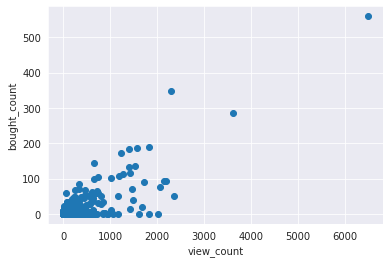

In [112]:
plt.scatter(final_features.view_count,final_features.bought_count)
plt.xlabel("view_count")
plt.ylabel("bought_count")
plt.show()

*well there is no high correlation between the view count and items bought as shown in graph*

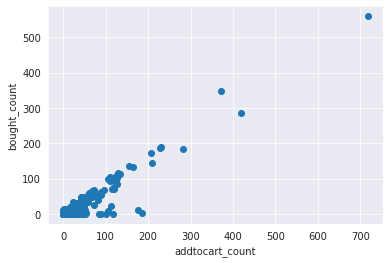

In [113]:
plt.scatter(final_features.addtocart_count,final_features.bought_count)
plt.xlabel("addtocart_count")
plt.ylabel("bought_count")
plt.show()

*There is some kind of linear correlation between both features*

In [114]:
final_features.loc[final_features["visitorid"].isin(nv),'label'] = 1
final_features.loc[(final_features.addtocart_count>0) &(final_features.bought_count>0)
,'label'] = 0
final_features.loc[final_features.visitorid.isin(nv),"no_view_purchase"] = 1 #user bought somthing without viewing it
final_features.loc[(final_features.bought_count/final_features.view_count) < 0.1, 
                  "label"]=1 # if the user view more than 200 items and bought less than 10 items


In [115]:
final_features.head()

,visitorid,view_count,bought_count,addtocart_count,no_view_purchase,label
0,0,3,0,0,0,1
1,1,1,0,0,0,1
2,2,8,0,0,0,1
3,3,1,0,0,0,1
4,4,1,0,0,0,1


In [116]:
final_features.label.value_counts()

1    1398610
0       8970
Name: label, dtype: int64

**Due to the huge imbalance between the 2 classes i think it will be a good choice if you down sampled the bigger calss**

In [117]:
normal = final_features[final_features.label==0]
abnormal = final_features[final_features.label==1]

In [118]:
abnormal = abnormal.sample(20000)

In [119]:
final_features = pd.concat([normal,abnormal],axis=0)
final_features.head()

,visitorid,view_count,bought_count,addtocart_count,no_view_purchase,label
186,186,2,1,1,0,0
264,264,3,2,2,0,0
419,419,4,1,1,0,0
539,539,4,1,2,0,0
914,914,1,1,1,0,0


In [120]:
print("number of normal is {0} ".format(len(normal)))

number of normal is 8970 


## Building our model 

In [121]:
data = final_features.drop(columns="label")
y = final_features["label"]
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    y,random_state = 42,
                                                    train_size = 0.7,
                                                    shuffle=True,
                                                    stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(20279, 5)
(8691, 5)
(20279,)
(8691,)


**simple Logistic regression**

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression()

In [123]:
lr_pred = logreg.predict(X_test)

In [124]:
print('recall_score = {:7.4f}'.format(metrics.recall_score(y_test, lr_pred)))
print('precision_score = {:7.4f}'.format(metrics.precision_score(y_test, lr_pred)))
print('f1_score = {:7.4f}'.format(metrics.f1_score(y_test, lr_pred)))

recall_score =  1.0000
precision_score =  0.6904
f1_score =  0.8168


**Random forest Ensamble model**

In [125]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4,criterion="entropy",max_features="auto")
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print('\nClassification Report\n',metrics.classification_report(y_test, rf_pred))


Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2691
           1       1.00      1.00      1.00      6000

    accuracy                           1.00      8691
   macro avg       1.00      1.00      1.00      8691
weighted avg       1.00      1.00      1.00      8691



**our model can easily predict abnormal user from the features we generated**